## Initial setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print(tf.__version__)
import torch
print(torch.__version__)
import matplotlib
print(matplotlib.__version__)

2.8.2
1.11.0+cu113
3.2.2


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
# Other imports
! pip install tensorflow_addons
! pip install tensorflow_io

import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_io as tfio
import tensorflow_hub as hub
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import sklearn.manifold
from sklearn.metrics.pairwise import cosine_similarity as cos
from sympy.utilities.iterables import multiset_permutations
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from IPython.display import Image, display


import zipfile
import concurrent.futures

# Random seed fix
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 1.3 MB/s 


## Dataset gathering and preparation

In [4]:
%cd /content/drive/MyDrive/nanowire-morphology-classification-project

/content/drive/MyDrive/nanowire-morphology-classification-project


In [5]:
training_batch_size = 4

BATCH_SIZE = training_batch_size

imageSize = 224

category_names = ['bundle', 'dispersed', 'network', 'singular']
color_method = ['C0', 'C1', 'C2', 'C3', 'C4']
color = ['black', 'magenta', 'cyan', 'yellow']
marker = ['o', 's', '<', '>', '^']
seaborn_palette = sns.color_palette("colorblind")

## Result plots for hyperparameter tuning

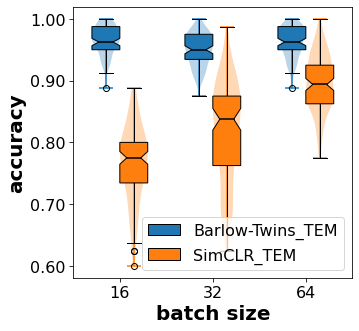

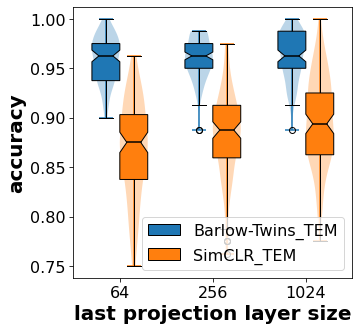

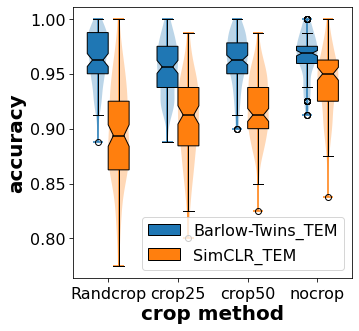

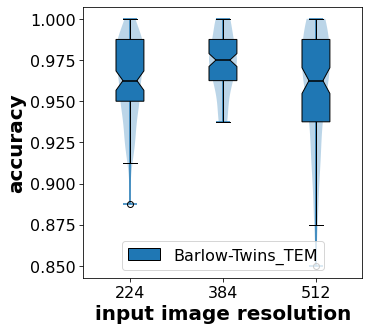

In [ ]:
# plot results from hyperparameter tuning for Barlow and Simclr trained on TEM images of protein / peptide nanowires
ss_method = ['simclr', 'barlow']
ss_batch_size = np.array([16, 32, 64])
phl_3 = np.array([64, 256, 1024])
res = np.array([224, 384, 512])

# the crop method used is a random crop size between 25% to 50% 
crop_parameter = ['crop25', 'crop50', 'nocrop']                  # here a constant 25% crop, 50% crop and no crop is explored

# boxplot and violin plot position box width parameter for adjusting the aesthestics
box_width = 0.3
shift = 0.15
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

hyperparameter_tuning_result = {}
for i in range(len(ss_method)):
  for j in range(len(ss_batch_size)):
    y = np.load('classify_scores_hyperparameter/%s_resnet_batch%i_project128_64_%i.npz'
        % (ss_method[i], ss_batch_size[j], phl_3[-1]), allow_pickle=True)
    hyperparameter_tuning_result.update({'%s_%i_%i' % (ss_method[i], ss_batch_size[j], phl_3[-1]): y['scores']})
  
  for j in range(len(phl_3)):
    y = np.load('classify_scores_hyperparameter/%s_resnet_batch%i_project128_64_%i.npz'
        % (ss_method[i], ss_batch_size[-1], phl_3[j]), allow_pickle=True)
    hyperparameter_tuning_result.update({'%s_%i_%i' % (ss_method[i], ss_batch_size[-1], phl_3[j]): y['scores']})

  for j in range(len(crop_parameter)):
    y = np.load('classify_scores_hyperparameter/%s_resnet_batch%i_project128_64_%i_%s.npz'
        % (ss_method[i], ss_batch_size[-1], phl_3[-1], crop_parameter[j]), allow_pickle=True)
    hyperparameter_tuning_result.update({'%s_%i_%i_%s' % (ss_method[i], ss_batch_size[-1], phl_3[-1], crop_parameter[j]): y['scores']})

for j in range(len(res)):
  y = np.load('classify_scores_hyperparameter/barlow_resnet_res%i_project128_64_%i.npz'
        % (res[j], phl_3[-1]), allow_pickle=True)
  hyperparameter_tuning_result.update({'res%i' % (res[j]): y['scores']})

# impact of batch size
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
plt.violinplot([np.reshape(hyperparameter_tuning_result['%s_%i_%i' % (ss_method[1], ss_batch_size[i], phl_3[-1])][:, :, :, 0], -1) for i in range(len(ss_batch_size))], widths=box_width, positions=np.arange(1, 4) - shift)
box1 = plt.boxplot([np.reshape(hyperparameter_tuning_result['%s_%i_%i' % (ss_method[1], ss_batch_size[i], phl_3[-1])][:, :, :, 0], -1) for i in range(len(ss_batch_size))], widths=box_width, positions=np.arange(1, 4) - shift, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[0]), medianprops=dict(color="black",linewidth=1.5))
plt.violinplot([np.reshape(hyperparameter_tuning_result['%s_%i_%i' % (ss_method[0], ss_batch_size[i], phl_3[-1])][:, :, :, 0], -1) for i in range(len(ss_batch_size))], widths=box_width, positions=np.arange(1, 4) + shift)
box2 = plt.boxplot([np.reshape(hyperparameter_tuning_result['%s_%i_%i' % (ss_method[0], ss_batch_size[i], phl_3[-1])][:, :, :, 0], -1)for i in range(len(ss_batch_size))], widths=box_width, positions=np.arange(1, 4) + shift, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[1]), medianprops=dict(color="black",linewidth=1.5))

ax.set_xticklabels((ss_batch_size.astype('str')))
ax.set_xticks((np.arange(1, 4)))
ax.set_xlim(0.5, 3.5)
ax.yaxis.set_major_formatter(FormatStrFormatter('%1.2f'))
ax.tick_params(labelsize=16, length=4)
ax.set_xlabel(r'batch size', fontsize=20, fontweight='bold')
ax.set_ylabel(r'accuracy', fontsize=20, fontweight='bold')
ax.legend([box1["boxes"][0], box2["boxes"][0]], ['Barlow-Twins_TEM', 'SimCLR_TEM'], fontsize=16, loc='lower right')

# impact of last projection layer size
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
plt.violinplot([np.reshape(hyperparameter_tuning_result['%s_%i_%i' % (ss_method[1], ss_batch_size[-1], phl_3[i])][:, :, :, 0], -1) for i in range(len(phl_3))], widths=box_width, positions=np.arange(1, 4) - shift)
box1 = plt.boxplot([np.reshape(hyperparameter_tuning_result['%s_%i_%i' % (ss_method[1], ss_batch_size[-1], phl_3[i])][:, :, :, 0], -1) for i in range(len(phl_3))], widths=box_width, positions=np.arange(1, 4) - shift, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[0]), medianprops=dict(color="black",linewidth=1.5))
plt.violinplot([np.reshape(hyperparameter_tuning_result['%s_%i_%i' % (ss_method[0], ss_batch_size[-1], phl_3[i])][:, :, :, 0], -1) for i in range(len(phl_3))], widths=box_width, positions=np.arange(1, 4) + shift)
box2 = plt.boxplot([np.reshape(hyperparameter_tuning_result['%s_%i_%i' % (ss_method[0], ss_batch_size[-1], phl_3[i])][:, :, :, 0], -1) for i in range(len(phl_3))], widths=box_width, positions=np.arange(1, 4) + shift, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[1]), medianprops=dict(color="black",linewidth=1.5))

ax.set_xticklabels((phl_3.astype('str')))
ax.set_xticks((np.arange(1, 4)))
ax.set_xlim(0.5, 3.5)
ax.yaxis.set_major_formatter(FormatStrFormatter('%1.2f'))
ax.tick_params(labelsize=16, length=4)
ax.set_xlabel(r'last projection layer size', fontsize=20, fontweight='bold')
ax.set_ylabel(r'accuracy', fontsize=20, fontweight='bold')
ax.legend([box1["boxes"][0], box2["boxes"][0]], ['Barlow-Twins_TEM', 'SimCLR_TEM'], fontsize=16, loc='lower right')

# impact of crop parameter
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
plt.violinplot([np.reshape(hyperparameter_tuning_result['%s_%i_%i' % (ss_method[1], ss_batch_size[-1], phl_3[-1])][:, :, :, 0], -1),
                np.reshape(hyperparameter_tuning_result['%s_%i_%i_%s' % (ss_method[1], ss_batch_size[-1], phl_3[-1], crop_parameter[0])][:, :, :, 0], -1),
                np.reshape(hyperparameter_tuning_result['%s_%i_%i_%s' % (ss_method[1], ss_batch_size[-1], phl_3[-1], crop_parameter[1])][:, :, :, 0], -1),
                np.reshape(hyperparameter_tuning_result['%s_%i_%i_%s' % (ss_method[1], ss_batch_size[-1], phl_3[-1], crop_parameter[2])][:, :, :, 0], -1)], widths=box_width, positions=np.arange(1, 5) - shift)
box1 = plt.boxplot([np.reshape(hyperparameter_tuning_result['%s_%i_%i' % (ss_method[1], ss_batch_size[-1], phl_3[-1])][:, :, :, 0], -1),
                np.reshape(hyperparameter_tuning_result['%s_%i_%i_%s' % (ss_method[1], ss_batch_size[-1], phl_3[-1], crop_parameter[0])][:, :, :, 0], -1),
                np.reshape(hyperparameter_tuning_result['%s_%i_%i_%s' % (ss_method[1], ss_batch_size[-1], phl_3[-1], crop_parameter[1])][:, :, :, 0], -1),
                np.reshape(hyperparameter_tuning_result['%s_%i_%i_%s' % (ss_method[1], ss_batch_size[-1], phl_3[-1], crop_parameter[2])][:, :, :, 0], -1)], widths=box_width, positions=np.arange(1, 5) - shift, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[0]), medianprops=dict(color="black",linewidth=1.5))
plt.violinplot([np.reshape(hyperparameter_tuning_result['%s_%i_%i' % (ss_method[0], ss_batch_size[-1], phl_3[-1])][:, :, :, 0], -1),
                np.reshape(hyperparameter_tuning_result['%s_%i_%i_%s' % (ss_method[0], ss_batch_size[-1], phl_3[-1], crop_parameter[0])][:, :, :, 0], -1),
                np.reshape(hyperparameter_tuning_result['%s_%i_%i_%s' % (ss_method[0], ss_batch_size[-1], phl_3[-1], crop_parameter[1])][:, :, :, 0], -1),
                np.reshape(hyperparameter_tuning_result['%s_%i_%i_%s' % (ss_method[0], ss_batch_size[-1], phl_3[-1], crop_parameter[2])][:, :, :, 0], -1)], widths=box_width, positions=np.arange(1, 5) + shift)
box2 = plt.boxplot([np.reshape(hyperparameter_tuning_result['%s_%i_%i' % (ss_method[0], ss_batch_size[-1], phl_3[-1])][:, :, :, 0], -1),
                np.reshape(hyperparameter_tuning_result['%s_%i_%i_%s' % (ss_method[0], ss_batch_size[-1], phl_3[-1], crop_parameter[0])][:, :, :, 0], -1),
                np.reshape(hyperparameter_tuning_result['%s_%i_%i_%s' % (ss_method[0], ss_batch_size[-1], phl_3[-1], crop_parameter[1])][:, :, :, 0], -1),
                np.reshape(hyperparameter_tuning_result['%s_%i_%i_%s' % (ss_method[0], ss_batch_size[-1], phl_3[-1], crop_parameter[2])][:, :, :, 0], -1)], widths=box_width, positions=np.arange(1, 5) + shift, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[1]), medianprops=dict(color="black",linewidth=1.5))

crop_legend = ['Randcrop']
crop_legend.extend(crop_parameter)
ax.set_xticklabels((crop_legend))
ax.set_xticks((np.arange(1, 5)))
ax.set_xlim(0.5, 4.5)
ax.yaxis.set_major_formatter(FormatStrFormatter('%1.2f'))
ax.tick_params(labelsize=16, length=4)
ax.set_xlabel(r'crop method', fontsize=20, fontweight='bold')
ax.set_ylabel(r'accuracy', fontsize=20, fontweight='bold')
ax.legend([box1["boxes"][0], box2["boxes"][0]], ['Barlow-Twins_TEM', 'SimCLR_TEM'], fontsize=16, loc='lower right')

# impact of input resolution
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

plt.violinplot([np.reshape(hyperparameter_tuning_result['res%i' % (res[i])][:, :, :, 0], -1) for i in range(len(res))], widths=box_width)
box1 = plt.boxplot([np.reshape(hyperparameter_tuning_result['res%i' % (res[i])][:, :, :, 0], -1) for i in range(len(res))], widths=box_width, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[0]), medianprops=dict(color="black",linewidth=1.5))

ax.set_xticklabels((res.astype('str')))
ax.set_xlim(0.5, 3.5)
ax.yaxis.set_major_formatter(FormatStrFormatter('%1.3f'))
ax.tick_params(labelsize=16, length=4)
ax.set_xlabel(r'input image resolution', fontsize=20, fontweight='bold')
ax.set_ylabel(r'accuracy', fontsize=20, fontweight='bold')
ax.legend([box1["boxes"][0]], ['Barlow-Twins_TEM'], fontsize=16, loc='lower center')

## Result plots for classification accuracy of protein / peptide nanowires TEM images in main manuscript

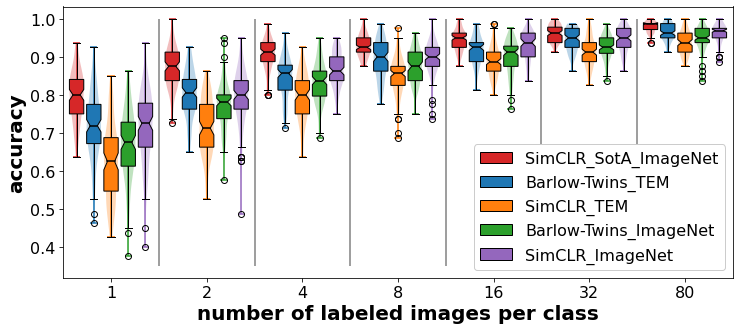

In [ ]:
# Random seed fix
random_seed_list = np.array([42, 43, 44, 45, 46])
random_seed_for_split = np.linspace(42, 42 + 19, 20).astype(int)
training_image_size = np.array([80, 32, 16, 8, 4, 2, 1])
data_percentage_legend = np.flip(np.arange(len(training_image_size)))

# boxplot and violin plot parameters for better aesthetics
box_width = 0.15
shift = 0.3
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors[3:4] + plt.cm.tab10.colors[0:3] + plt.cm.tab10.colors[4:5])    # avoid having both green and red in the same boxplot format
# list of models
models = ['barlow_tem', 'simclr_tem', 'barlow_ImageNet', 'simclr_ImageNet', 'simclr_ImageNet_sota']

classification_result = {}
for i in range(len(models)):
  y = np.load('classify_scores_main_result/%s_classification_result.npz' % (models[i])
      , allow_pickle=True)
  classification_result.update({'%s' % (models[i]): y['scores']})

# plot the scores versus different models and data percentages
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

plt.violinplot([np.reshape(classification_result[models[4]][i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 1.2)
box0 = plt.boxplot([np.reshape(classification_result[models[4]][i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 1.2, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[0]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot([np.reshape(classification_result[models[0]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.6)
box1 = plt.boxplot([np.reshape(classification_result[models[0]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.6, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[1]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot([np.reshape(classification_result[models[1]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8))
box2 = plt.boxplot([np.reshape(classification_result[models[1]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8), notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[2]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot([np.reshape(classification_result[models[2]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.6) 
box3 = plt.boxplot([np.reshape(classification_result[models[2]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.6, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[3]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot([np.reshape(classification_result[models[3]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 1.2)
box4 = plt.boxplot([np.reshape(classification_result[models[3]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 1.2, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[4]), medianprops=dict(color="black",linewidth=1.5))


for i in range(6):
  ax.vlines(1.5 + i, 0.35, 1.0, colors='grey')
ax.set_xticks((data_percentage_legend + 1))
ax.set_xticklabels((training_image_size).astype(str))
ax.set_xlim(0.5, 7.5)
ax.tick_params(labelsize=16, length=4)
ax.set_xlabel(r'number of labeled images per class', fontsize=20, fontweight='bold')
ax.set_ylabel(r'accuracy', fontsize=20, fontweight='bold')
ax.legend([box0["boxes"][0], box1["boxes"][0], box2["boxes"][0], box3["boxes"][0], box4["boxes"][0]], ['SimCLR_SotA_ImageNet', 'Barlow-Twins_TEM', 'SimCLR_TEM', 'Barlow-Twins_ImageNet', 'SimCLR_ImageNet'], fontsize=16, loc='lower right', framealpha=1)

## Result plots for classification accuracy of metal nanoparticles (mNP) TEM images in main manuscript

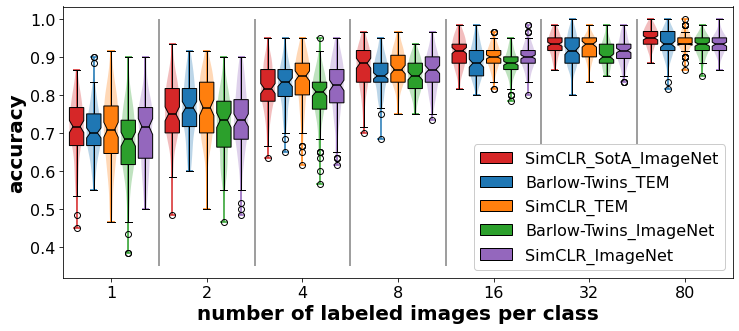

In [ ]:
# Random seed fix
random_seed_list = np.array([42, 43, 44, 45, 46])
random_seed_for_split = np.linspace(42, 42 + 19, 20).astype(int)
training_image_size = np.array([80, 32, 16, 8, 4, 2, 1])
data_percentage_legend = np.flip(np.arange(len(training_image_size)))

# boxplot and violin plot parameters for better aesthetics
box_width = 0.15
shift = 0.3
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors[3:4] + plt.cm.tab10.colors[0:3] + plt.cm.tab10.colors[4:5])    # avoid having both green and red in the same boxplot format
# list of models
models = ['barlow_tem', 'simclr_tem', 'barlow_ImageNet', 'simclr_ImageNet', 'simclr_ImageNet_sota']

classification_result = {}
for i in range(len(models)):
  y = np.load('mNP-classify_scores/%s_classification_result.npz' % (models[i])
      , allow_pickle=True)
  classification_result.update({'%s' % (models[i]): y['scores']})

# plot the scores versus different models and data percentages
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

plt.violinplot([np.reshape(classification_result[models[4]][i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 1.2)
box0 = plt.boxplot([np.reshape(classification_result[models[4]][i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 1.2, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[0]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot([np.reshape(classification_result[models[0]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.6)
box1 = plt.boxplot([np.reshape(classification_result[models[0]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.6, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[1]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot([np.reshape(classification_result[models[1]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8))
box2 = plt.boxplot([np.reshape(classification_result[models[1]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8), notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[2]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot([np.reshape(classification_result[models[2]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.6) 
box3 = plt.boxplot([np.reshape(classification_result[models[2]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.6, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[3]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot([np.reshape(classification_result[models[3]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 1.2)
box4 = plt.boxplot([np.reshape(classification_result[models[3]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 1.2, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[4]), medianprops=dict(color="black",linewidth=1.5))


for i in range(6):
  ax.vlines(1.5 + i, 0.35, 1.0, colors='grey')
ax.set_xticks((data_percentage_legend + 1))
ax.set_xticklabels((training_image_size).astype(str))
ax.set_xlim(0.5, 7.5)
ax.tick_params(labelsize=16, length=4)
ax.set_xlabel(r'number of labeled images per class', fontsize=20, fontweight='bold')
ax.set_ylabel(r'accuracy', fontsize=20, fontweight='bold')
ax.legend([box0["boxes"][0], box1["boxes"][0], box2["boxes"][0], box3["boxes"][0], box4["boxes"][0]], ['SimCLR_SotA_ImageNet', 'Barlow-Twins_TEM', 'SimCLR_TEM', 'Barlow-Twins_ImageNet', 'SimCLR_ImageNet'], fontsize=16, loc='lower right', framealpha=1)

## Result plots for classification accuracy of TEM viruses dataset in main manuscript

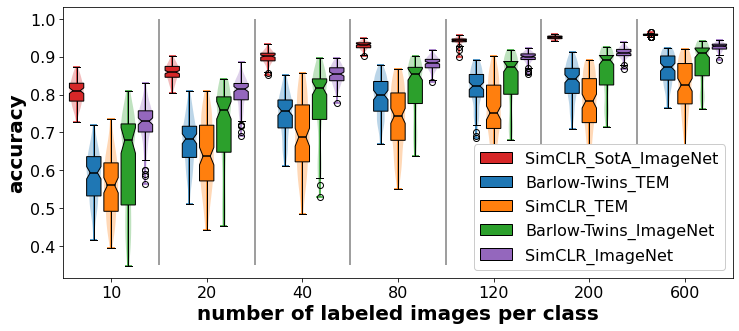

In [ ]:
# Random seed fix
random_seed_list = np.array([42, 43, 44, 45, 46])
random_seed_for_split = np.linspace(42, 42 + 19, 20).astype(int)
training_image_size = np.array([600, 200, 120, 80, 40, 20, 10])
data_percentage_legend = np.flip(np.arange(len(training_image_size)))

# boxplot and violin plot parameters for better aesthetics
box_width = 0.15
shift = 0.3
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors[3:4] + plt.cm.tab10.colors[0:3] + plt.cm.tab10.colors[4:5])    # avoid having both green and red in the same boxplot format
# list of models
models = ['barlow_tem', 'simclr_tem', 'barlow_ImageNet', 'simclr_ImageNet', 'simclr_ImageNet_sota']

classification_result = {}
for i in range(len(models)):
  y = np.load('TEM-virus-classify_scores/%s_classification_result.npz' % (models[i])
      , allow_pickle=True)
  classification_result.update({'%s' % (models[i]): y['scores']})

# plot the scores versus different models and data percentages
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

plt.violinplot([np.reshape(classification_result[models[4]][i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 1.2)
box0 = plt.boxplot([np.reshape(classification_result[models[4]][i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 1.2, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[0]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot([np.reshape(classification_result[models[0]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.6)
box1 = plt.boxplot([np.reshape(classification_result[models[0]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.6, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[1]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot([np.reshape(classification_result[models[1]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8))
box2 = plt.boxplot([np.reshape(classification_result[models[1]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8), notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[2]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot([np.reshape(classification_result[models[2]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.6) 
box3 = plt.boxplot([np.reshape(classification_result[models[2]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.6, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[3]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot([np.reshape(classification_result[models[3]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 1.2)
box4 = plt.boxplot([np.reshape(classification_result[models[3]][i, :, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 1.2, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[4]), medianprops=dict(color="black",linewidth=1.5))


for i in range(6):
  ax.vlines(1.5 + i, 0.35, 1.0, colors='grey')
ax.set_xticks((data_percentage_legend + 1))
ax.set_xticklabels((training_image_size).astype(str))
ax.set_xlim(0.5, 7.5)
ax.tick_params(labelsize=16, length=4)
ax.set_xlabel(r'number of labeled images per class', fontsize=20, fontweight='bold')
ax.set_ylabel(r'accuracy', fontsize=20, fontweight='bold')
ax.legend([box0["boxes"][0], box1["boxes"][0], box2["boxes"][0], box3["boxes"][0], box4["boxes"][0]], ['SimCLR_SotA_ImageNet', 'Barlow-Twins_TEM', 'SimCLR_TEM', 'Barlow-Twins_ImageNet', 'SimCLR_ImageNet'], fontsize=16, loc='lower right', framealpha=1)

## Result plots for segmentation model performance on protein / peptide nanowire TEM images in main manuscript and in supporting information

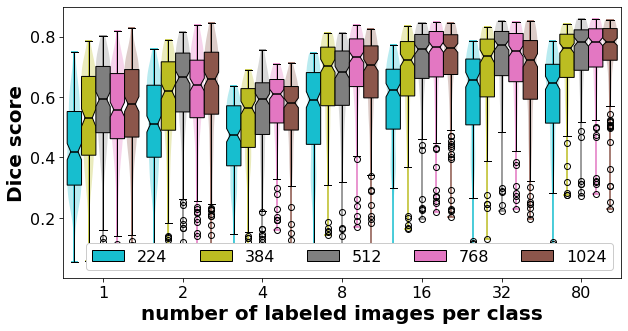

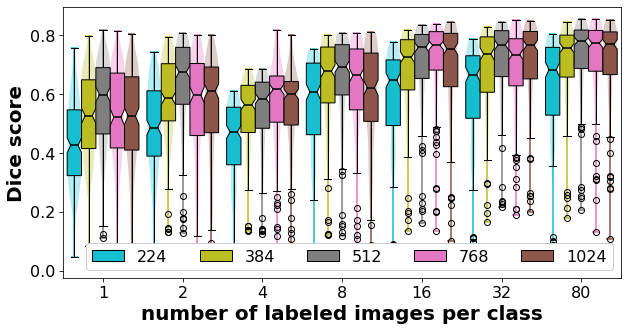

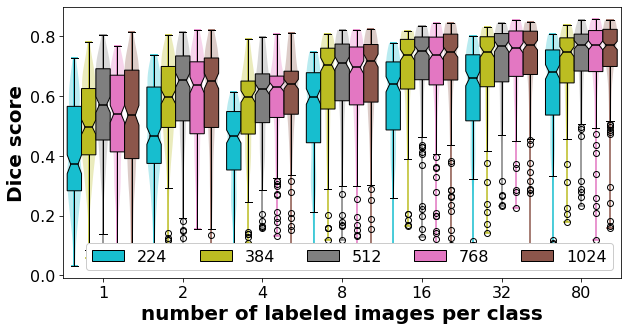

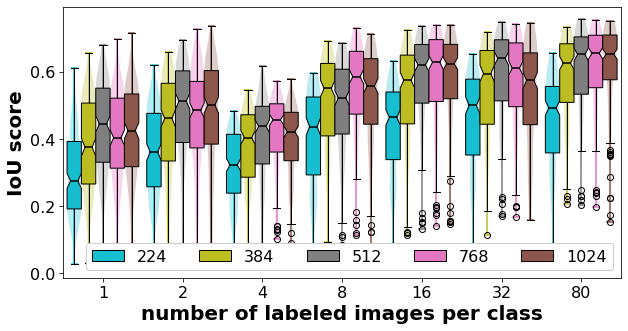

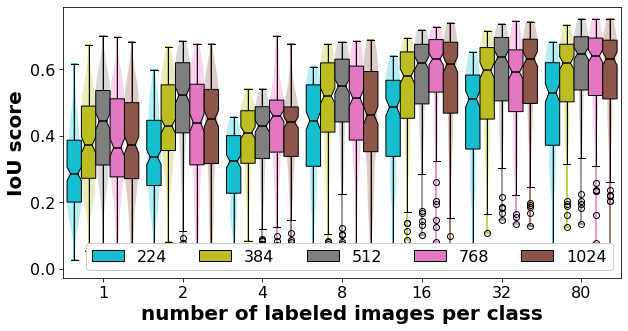

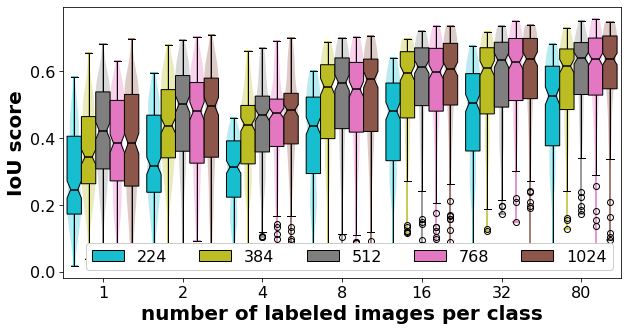

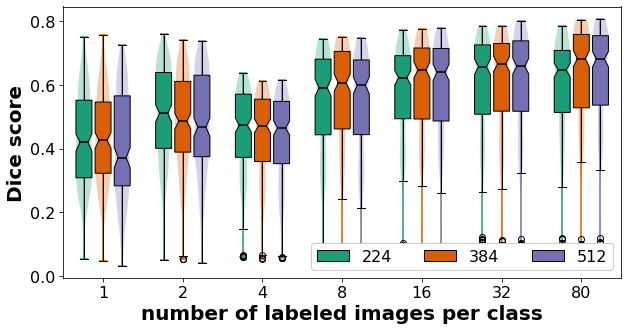

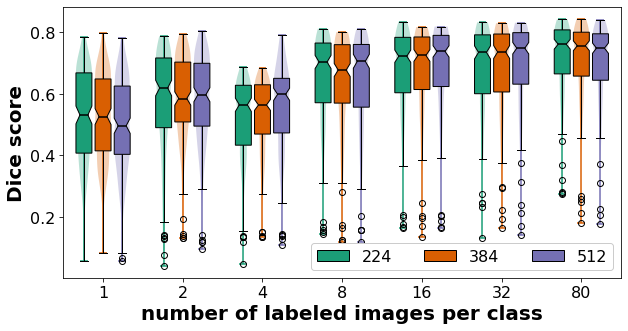

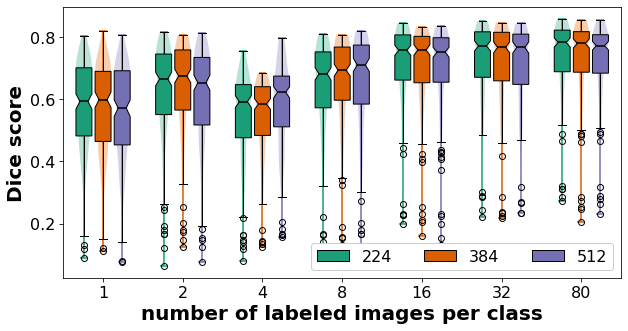

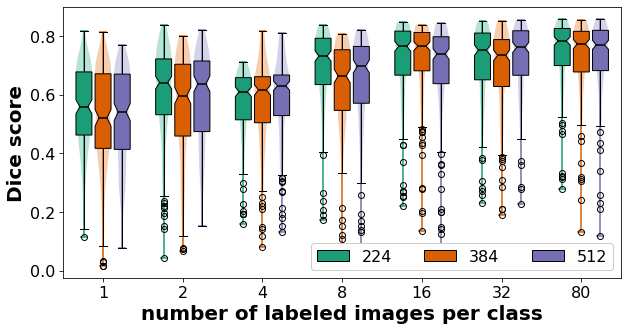

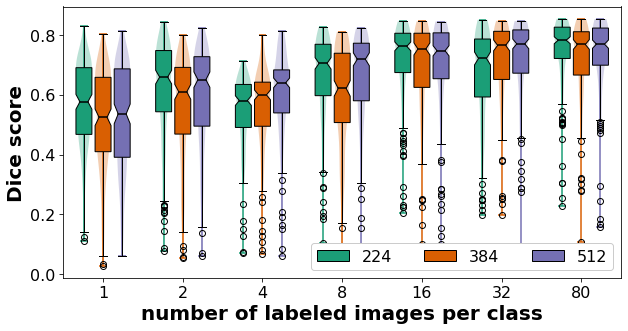

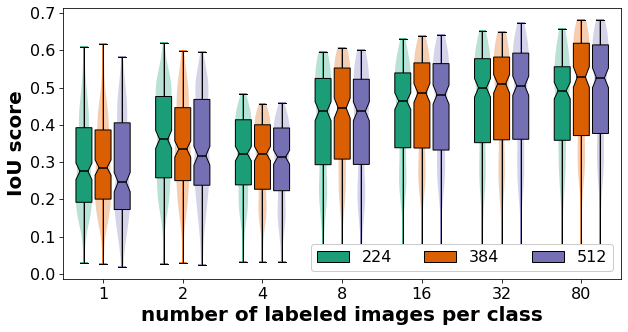

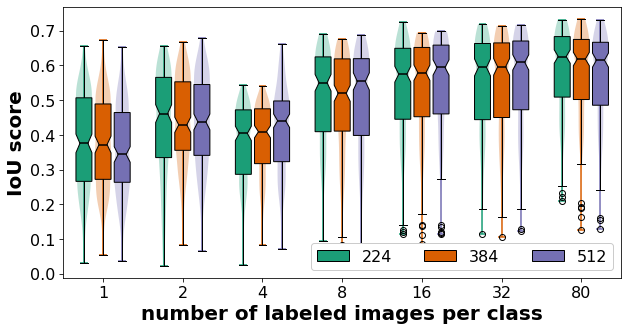

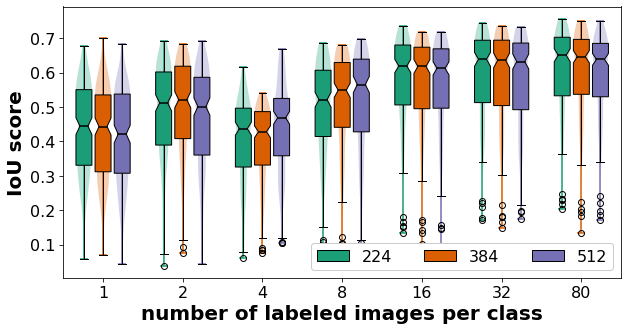

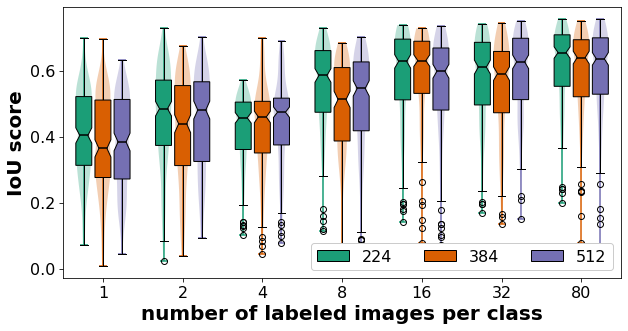

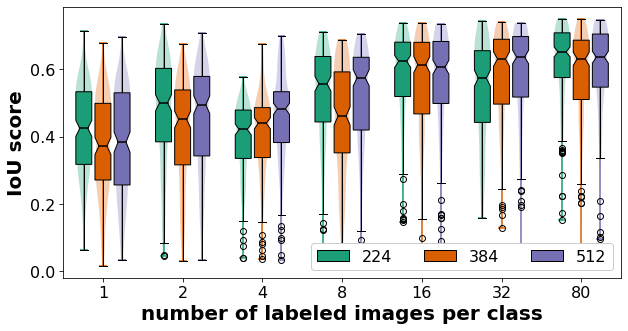

In [6]:
# Random seed fix
random_seed_list = np.array([42, 43, 44, 45, 46])
random_seed_for_split = np.array([42])
training_image_size = np.array([80, 32, 16, 8, 4, 2, 1])
data_percentage_legend = np.flip(np.arange(len(training_image_size)))
res = np.array([224, 384, 512, 768, 1024])
encoder_res = np.array([224, 384, 512])

# boxplot and violin plot parameters for better aesthetics
box_width = 0.18
shift = 0.45

segmentation_result = np.zeros((len(res), len(encoder_res), len(random_seed_list), len(random_seed_for_split), len(training_image_size), 40, 2))
for i in range(len(res)):
  for j in range(len(encoder_res)):
    for k in range(len(random_seed_list)):
      for m in range(len(random_seed_for_split)):
        segmentation_result[i, j, k, m] = np.load('segmentation_scores_main_result/res%i_enc_res%i_seed%i_seed%i.npz' %(res[i], encoder_res[j], random_seed_list[k], random_seed_for_split[m])
            , allow_pickle=True)['scores']

seg_result_average = np.average(segmentation_result, axis=(2, 3, -2))
seg_result_std = np.std(segmentation_result, axis=(2, 3, -2))


color_map1 = plt.cm.tab10.colors[::-1]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_map1)
# boxplot overlay with violinplot
# effect of segmentation image resolution at different encoder_resolutions
for j in range(len(encoder_res)):
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111)
  box1 = plt.boxplot([np.reshape(segmentation_result[0, j, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.8, notch=True, patch_artist=True, boxprops=dict(facecolor=color_map1[0]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[0, j, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.8)
  box2 = plt.boxplot([np.reshape(segmentation_result[1, j, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.4, notch=True, patch_artist=True, boxprops=dict(facecolor=color_map1[1]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[1, j, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.4)
  box3 = plt.boxplot([np.reshape(segmentation_result[2, j, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8), notch=True, patch_artist=True, boxprops=dict(facecolor=color_map1[2]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[2, j, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8))
  box4 = plt.boxplot([np.reshape(segmentation_result[3, j, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.4, notch=True, patch_artist=True, boxprops=dict(facecolor=color_map1[3]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[3, j, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.4)
  box5 = plt.boxplot([np.reshape(segmentation_result[4, j, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.8, notch=True, patch_artist=True, boxprops=dict(facecolor=color_map1[4]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[4, j, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.8)

  ax.set_xticks((data_percentage_legend + 1))
  ax.set_xticklabels((training_image_size).astype(str))
  ax.set_xlim(0.5, 7.5)
  ax.tick_params(labelsize=16, length=4)
  ax.set_xlabel(r'number of labeled images per class', fontsize=20, fontweight='bold')
  ax.set_ylabel(r'Dice score', fontsize=20, fontweight='bold')
  ax.legend([box1["boxes"][0], box2["boxes"][0], box3["boxes"][0], box4["boxes"][0], box5["boxes"][0]], ['%i' % res[i] for i in range(len(res))], fontsize=16, loc='lower right', framealpha=1, ncol=5)

for j in range(len(encoder_res)):
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111)
  box1 = plt.boxplot([np.reshape(segmentation_result[0, j, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.8, notch=True, patch_artist=True, boxprops=dict(facecolor=color_map1[0]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[0, j, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.8)
  box2 = plt.boxplot([np.reshape(segmentation_result[1, j, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.4, notch=True, patch_artist=True, boxprops=dict(facecolor=color_map1[1]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[1, j, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.4)
  box3 = plt.boxplot([np.reshape(segmentation_result[2, j, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8), notch=True, patch_artist=True, boxprops=dict(facecolor=color_map1[2]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[2, j, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8))
  box4 = plt.boxplot([np.reshape(segmentation_result[3, j, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.4, notch=True, patch_artist=True, boxprops=dict(facecolor=color_map1[3]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[3, j, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.4)
  box5 = plt.boxplot([np.reshape(segmentation_result[4, j, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.8, notch=True, patch_artist=True, boxprops=dict(facecolor=color_map1[4]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[4, j, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.8)

  ax.set_xticks((data_percentage_legend + 1))
  ax.set_xticklabels((training_image_size).astype(str))
  ax.set_xlim(0.5, 7.5)
  ax.tick_params(labelsize=16, length=4)
  ax.set_xlabel(r'number of labeled images per class', fontsize=20, fontweight='bold')
  ax.set_ylabel(r'IoU score', fontsize=20, fontweight='bold')
  ax.legend([box1["boxes"][0], box2["boxes"][0], box3["boxes"][0], box4["boxes"][0], box5["boxes"][0]], ['%i' % res[i] for i in range(len(res))], fontsize=16, loc='lower right', framealpha=1, ncol=5)

color_map2 = plt.cm.Dark2.colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_map2)
box_width = 0.2
shift = 0.6

# effect of image resolution encoder trained on at different segmentation image resolutions
for j in range(len(res)):
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111)
  box1 = plt.boxplot([np.reshape(segmentation_result[j, 0, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.4, notch=True, patch_artist=True, boxprops=dict(facecolor=color_map2[0]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[j, 0, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.4)
  box2 = plt.boxplot([np.reshape(segmentation_result[j, 1, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8), notch=True, patch_artist=True, boxprops=dict(facecolor=color_map2[1]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[j, 1, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8))
  box3 = plt.boxplot([np.reshape(segmentation_result[j, 2, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.4, notch=True, patch_artist=True, boxprops=dict(facecolor=color_map2[2]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[j, 2, :, :, i, :, 1], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.4)

  ax.set_xticks((data_percentage_legend + 1))
  ax.set_xticklabels((training_image_size).astype(str))
  ax.set_xlim(0.5, 7.5)
  ax.tick_params(labelsize=16, length=4)
  ax.set_xlabel(r'number of labeled images per class', fontsize=20, fontweight='bold')
  ax.set_ylabel(r'Dice score', fontsize=20, fontweight='bold')
  ax.legend([box1["boxes"][0], box2["boxes"][0], box3["boxes"][0]], ['%i' % encoder_res[i] for i in range(len(encoder_res))], fontsize=16, loc='lower right', framealpha=1, ncol=3)


for j in range(len(res)):
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111)
  box1 = plt.boxplot([np.reshape(segmentation_result[j, 0, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.4, notch=True, patch_artist=True, boxprops=dict(facecolor=color_map2[0]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[j, 0, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) - shift * 0.4)
  box2 = plt.boxplot([np.reshape(segmentation_result[j, 1, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8), notch=True, patch_artist=True, boxprops=dict(facecolor=color_map2[1]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[j, 1, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8))
  box3 = plt.boxplot([np.reshape(segmentation_result[j, 2, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.4, notch=True, patch_artist=True, boxprops=dict(facecolor=color_map2[2]), medianprops=dict(color="black",linewidth=1.5))
  plt.violinplot([np.reshape(segmentation_result[j, 2, :, :, i, :, 0], -1) for i in data_percentage_legend], widths=box_width, positions=np.arange(1, 8) + shift * 0.4)

  ax.set_xticks((data_percentage_legend + 1))
  ax.set_xticklabels((training_image_size).astype(str))
  ax.set_xlim(0.5, 7.5)
  ax.tick_params(labelsize=16, length=4)
  ax.set_xlabel(r'number of labeled images per class', fontsize=20, fontweight='bold')
  ax.set_ylabel(r'IoU score', fontsize=20, fontweight='bold')
  ax.legend([box1["boxes"][0], box2["boxes"][0], box3["boxes"][0]], ['%i' % encoder_res[i] for i in range(len(encoder_res))], fontsize=16, loc='lower right', framealpha=1, ncol=3)
